# Cancer classification

The objective of this project is to identify what type of cancer a patient has by analyzing his/her gene expression.
The 44 features `gene_XX` are real numbers representing gene expression levels obtained from RNA sequencing.
The target is modeled as multi-class integer classification with `Class` ranging from 1 to 5.

The type of cancers in the dataset and the mappings are the following:
1. BRCA — Breast invasive carcinoma
1. KIRC — Kidney renal clear cell carcinoma
1. COAD — Colon adenocarcinoma
1. LUAD — Lung adenocarcinoma
1. PRAD — Prostate adenocarcinoma

The benchmark for this classification problem is Classifying Cancer Patients Based on DNA Sequences Using Machine Learning by Hussain, Fahad & Saeed, Umair & Islam, Noman & Sheikh, Ghazala, published on Journal of Medical Imaging and Health Informatics in 2019.

For a fast exploration of learning models I’ll use `pycaret`.

In [1]:
# Install pycaret in the current Python kernel
import sys
!{sys.executable} -m pip install -q pycaret

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Now let’s import libraries for DataFrame management and classification.

In [2]:
# DataFrane library
import pandas as pd

# Processing and modeling library
from pycaret.classification import *

%config InlineBackend.figure_format = 'retina'

The data is available locally in the `input` path.

In [3]:
# Reading the data
df = pd.read_csv('../input/cancer-dna-patients-dataset/DNA_Dataset_Normalized.csv')
# Shuffling the data
df = df.sample(frac=1, random_state=42)

# The gene_23 column is made up of zeroes
print('The variance of gene_23 is', df.gene_23.var())

The variance of gene_23 is 0.0


I’ll drop the feature `gene_23` since it has null variance and it’s useless from a training perspective, then store feature names in a list.

In [4]:
df = df.drop(columns='gene_23')

# Feature names
features = df.iloc[:,:-1].columns.tolist()

Now we can setup the learning environment.

The training DataFrame is `df`, with target `Class`.
I’m explicitly setting the data types as numeric to avoid inference issues. This first run of `setup` and `compare_models` will evaluate the models without performing any preprocessing on data.

I’m explicitly blacklisting Yandex CatBoost, Support Vector Machine with radial kernel and Gaussian Process Classifier models to avoid long training times.

In [5]:
# Setup the environment
setup(data = df,                    # Training data
      target = 'Class',             # Target to classify
      train_size = 0.8,             # Train-Test sets split
      numeric_features = features,  # Setting the numerical features
      session_id = 42,              # Seed
      verbose = False,              # Show results only
      silent = True)                # Don’t require confirmation

compare_models(blacklist=['catboost', 'rbfsvm', 'gpc'], turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9454,0.0000,0.9462,0.9530,0.9442,0.9317,0.9341,1.0548
1,Linear Discriminant Analysis,0.9453,0.0000,0.9452,0.9497,0.9452,0.9315,0.9327,0.0410
2,MLP Classifier,0.9420,0.0000,0.9414,0.9467,0.9408,0.9274,0.9292,3.4312
3,Ridge Classifier,0.9420,0.0000,0.9419,0.9458,0.9418,0.9275,0.9285,0.0322
4,Logistic Regression,0.9325,0.0000,0.9329,0.9394,0.9312,0.9155,0.9181,0.1844
5,Extreme Gradient Boosting,0.9231,0.0000,0.9229,0.9282,0.9220,0.9038,0.9056,0.2719
6,Light Gradient Boosting Machine,0.9165,0.0000,0.9162,0.9304,0.9137,0.8956,0.9001,0.3889
7,K Neighbors Classifier,0.9070,0.0000,0.9067,0.9299,0.9028,0.8835,0.8906,0.0224
8,Ada Boost Classifier,0.9006,0.0000,0.8990,0.9159,0.8997,0.8755,0.8795,0.7822
9,Random Forest Classifier,0.8940,0.0000,0.8943,0.9115,0.8917,0.8673,0.8726,0.4064


OneVsRestClassifier(estimator=ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, 

As next step we can check if standardizing the data through a z-score normalization increases predicting accuracy. Also, the `group_features` option aggregates specified features (in this case all of them) and computes minimum, maximum, mean, median, and standard deviation for each data sample.

In [16]:
# Setup the environment
setup(data = df,                    # Training data
      target = 'Class',             # Target to classify
      train_size = 0.8,             # Train-Test sets split
      numeric_features = features,  # Setting the numerical features
      normalize = True,             # Z-Score normalization
      group_features = features,    # Aggregate
      session_id = 42,              # Seed
      verbose = False,              # Show re
      silent = True)                # Don’t require confirmation


best_model = compare_models(blacklist=['catboost', 'rbfsvm', 'gpc'], turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Linear Discriminant Analysis,0.9485,0.0000,0.9481,0.9520,0.9483,0.9355,0.9365,0.0363
1,Ridge Classifier,0.9453,0.0000,0.9452,0.9499,0.9449,0.9315,0.9329,0.0304
2,Extra Trees Classifier,0.9293,0.0000,0.9295,0.9410,0.9279,0.9116,0.9153,1.0717
3,Logistic Regression,0.9291,0.0000,0.9281,0.9363,0.9279,0.9113,0.9135,0.0650
4,SVM - Linear Kernel,0.9228,0.0000,0.9224,0.9296,0.9212,0.9034,0.9058,0.0284
5,MLP Classifier,0.9227,0.0000,0.9210,0.9279,0.9214,0.9032,0.9050,1.8059
6,Ada Boost Classifier,0.9198,0.0000,0.9195,0.9305,0.9186,0.8995,0.9030,0.8201
7,Light Gradient Boosting Machine,0.9165,0.0000,0.9162,0.9247,0.9155,0.8956,0.8981,0.4892
8,Extreme Gradient Boosting,0.9164,0.0000,0.9157,0.9262,0.9158,0.8954,0.8981,0.2921
9,Random Forest Classifier,0.8939,0.0000,0.8938,0.9133,0.8929,0.8672,0.8725,0.3986


The accuracy increased slightly.

Once the learning environment is set up and the data is preprocessed, we can explore the hyperparameter space and tune the top performing model.

In [17]:
# Tuning the hyperparameters
tuned_model = tune_model(best_model, n_iter=100, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,0.9355,0.0000,0.9333,0.9395,0.9351,0.9192,0.9204
3,0.9032,0.0000,0.9048,0.9014,0.9001,0.8789,0.8801
4,0.8710,0.0000,0.8762,0.8702,0.8685,0.8388,0.8398
5,0.9355,0.0000,0.9333,0.9516,0.9372,0.9193,0.9229
6,0.9032,0.0000,0.9000,0.9171,0.9017,0.8789,0.8824
7,0.9355,0.0000,0.9333,0.9395,0.9351,0.9192,0.9204
8,0.9032,0.0000,0.9000,0.9171,0.9017,0.8789,0.8824
9,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609


In [18]:
# Calibrating the tuned model
calibrated_model = calibrate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9688,0.0000,0.9667,0.9727,0.9684,0.9608,0.9620
2,0.9355,0.0000,0.9333,0.9395,0.9351,0.9192,0.9204
3,0.9677,0.0000,0.9667,0.9718,0.9674,0.9596,0.9608
4,0.8387,0.0000,0.8476,0.8500,0.8372,0.7987,0.8029
5,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609
6,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609
7,0.9355,0.0000,0.9333,0.9355,0.9355,0.9193,0.9193
8,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609
9,0.9355,0.0000,0.9333,0.9401,0.9353,0.9193,0.9205


# Testing the model

After the calibration we can apply the model to the test set and confront the results with the paper we took as benchmark.

In [36]:
prediction = predict_model(calibrated_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.9615,0,0.9617,0.9623,0.9615,0.9519,0.9521


The reference paper presents a Random Forest Classifier as best predicting model, with the following scores.

$$\text{Accuracy} = 0.9402$$

$$\text{Cohen’s kappa} = 0.9249$$

As we can see our Linear Discriminant Analysis classifier significantly outperformed the benchmark.
We can furtherly examine our model by plotting different attributes.  

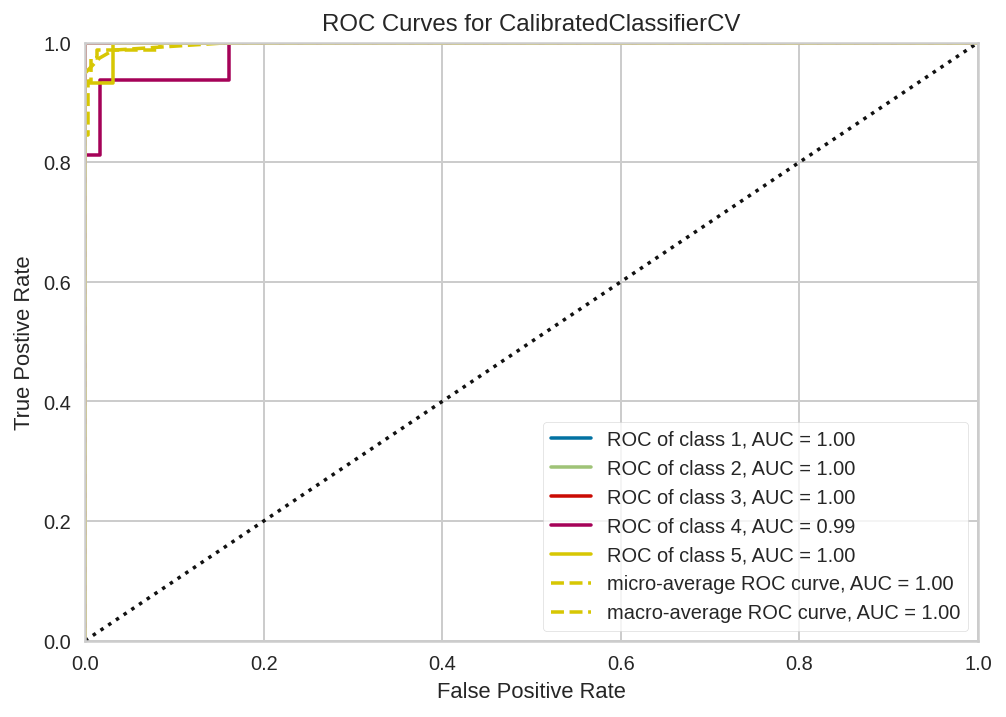

In [26]:
plot_model(calibrated_model, plot='auc')

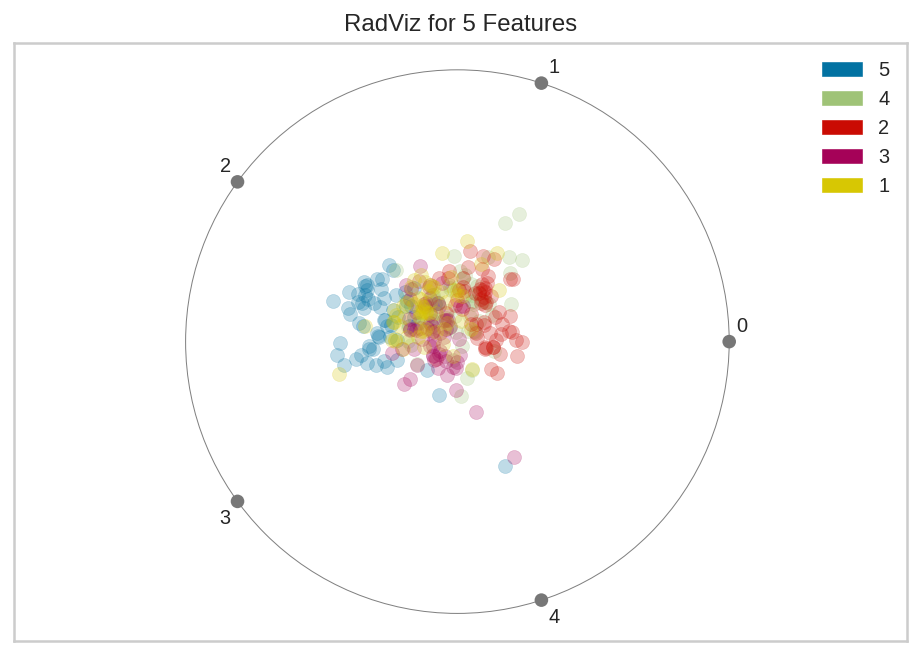

In [27]:
plot_model(calibrated_model, plot='dimension')

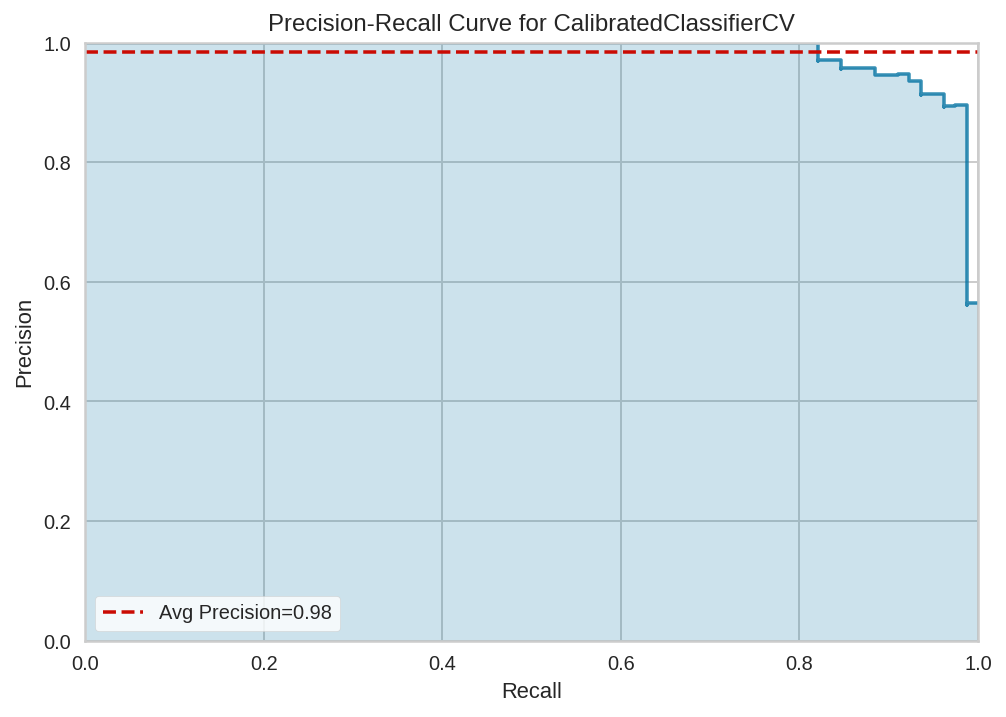

In [28]:
plot_model(calibrated_model, plot='pr')

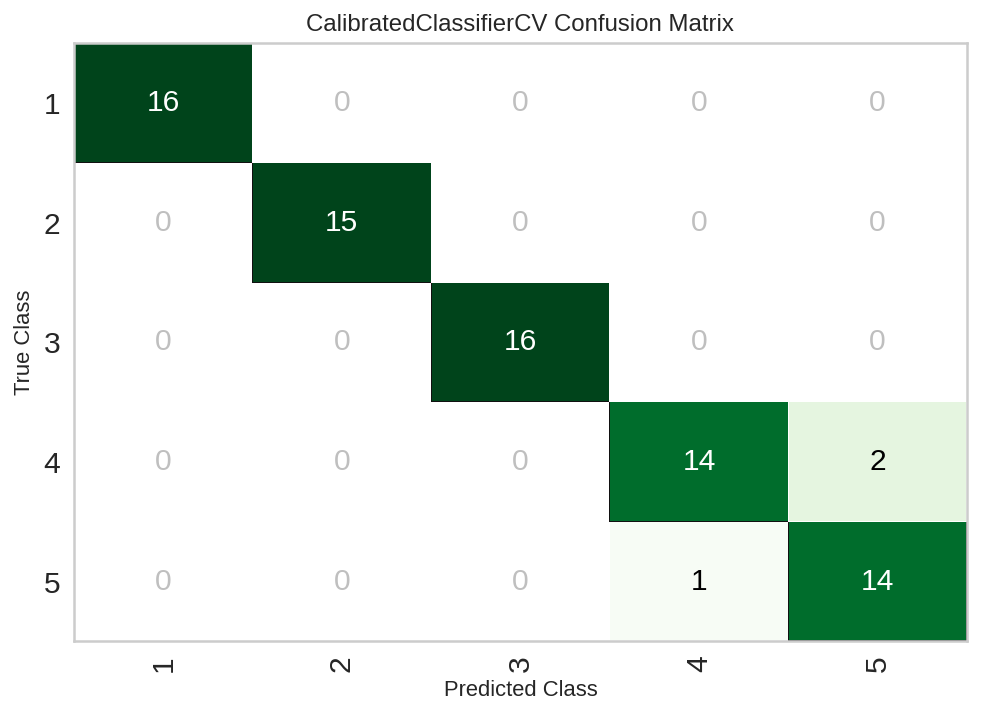

In [29]:
plot_model(calibrated_model, plot='confusion_matrix')

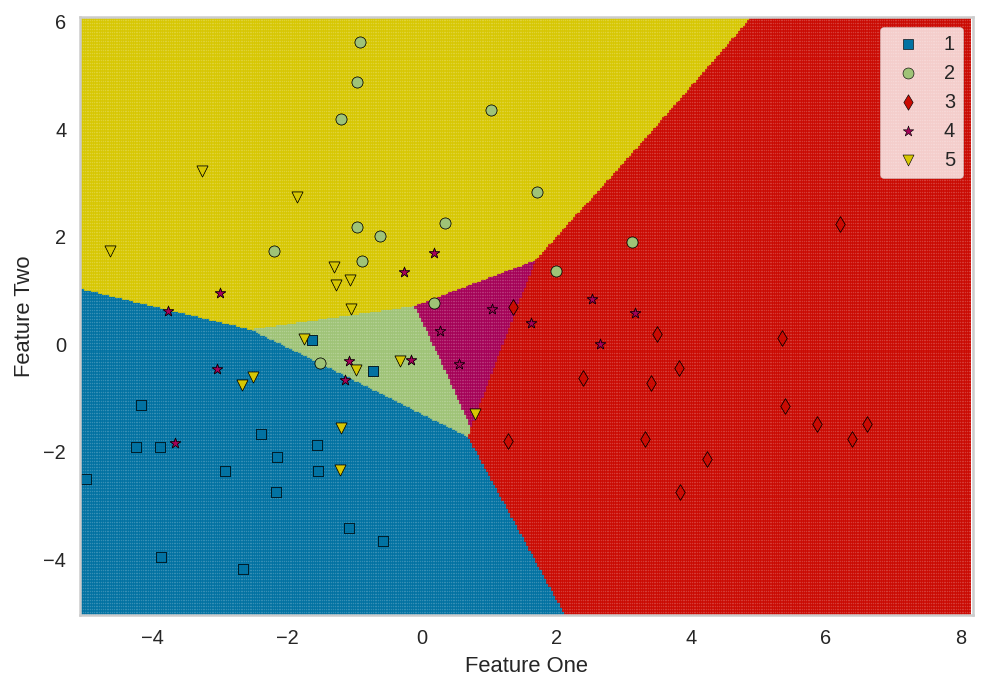

In [31]:
plot_model(calibrated_model, plot='boundary')

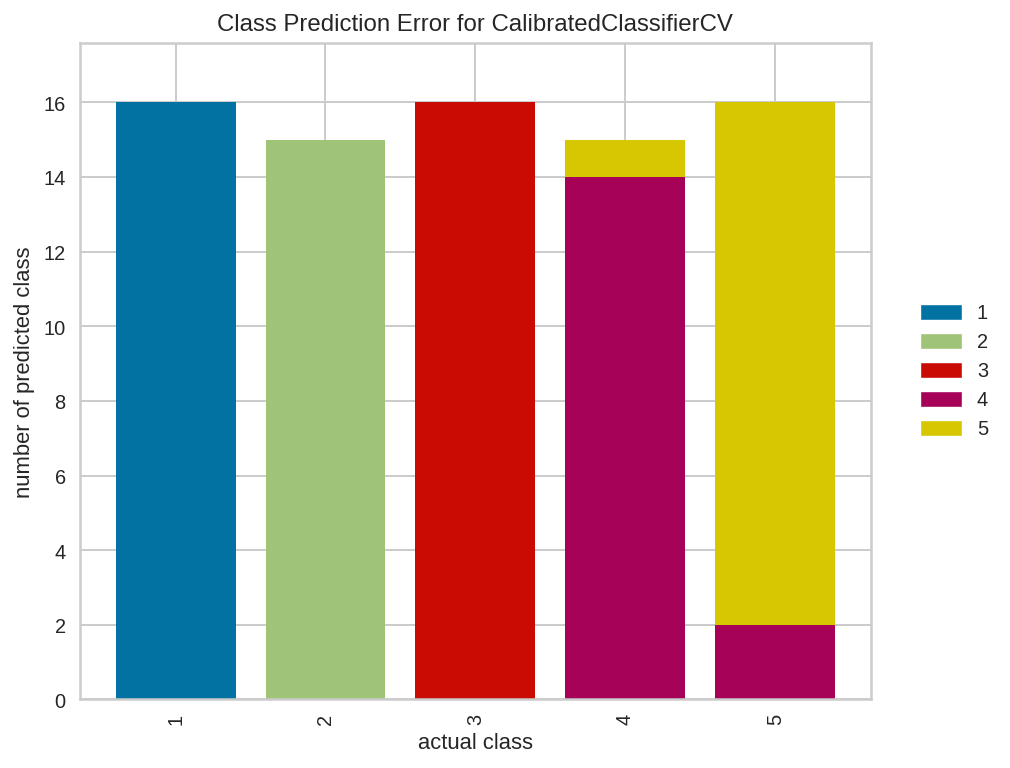

In [32]:
plot_model(calibrated_model, plot='error')